# Abstention Loss for Regression
author: Elizabeth A. Barnes, Randal J. Barnes

version: v1.8

date: March 21, 2021


In [1]:
import numpy as np
import time
import sys
import collections
import os
import glob
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import optimizers
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ct
import cartopy.crs as ccrs
import seaborn as sns

import abstentionloss as abstentionloss
import metrics as metrics
import network as network
import plots as plots
import climatedata as climatedata
import experiments as experiments
import twoDdata as twoDdata

import imp
imp.reload(experiments)
imp.reload(abstentionloss)
imp.reload(plots)
imp.reload(climatedata)
imp.reload(twoDdata)

import palettable
import pprint

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
tf.print(f"sys.version = {sys.version}", output_stream=sys.stdout)
tf.print(f"tf.version.VERSION = {tf.version.VERSION}", output_stream=sys.stdout)

sys.version = 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
tf.version.VERSION = 2.4.1


In [2]:
SCRIPT_NAME = '_trainReg_cmdA.py'
checkpointDir = '/Users/eabarnes/Data/2021/abstention_loss/checkpoints/'

In [3]:
# EXP_NAME = 'tranquilFOOr22'
# EXP_NAME = 'corruptInputsr25'
# EXP_NAME = 'olsr1'
EXP_NAME = 'olsr0'
EXPINFO = experiments.define_experiments(EXP_NAME)
pprint.pprint(EXPINFO, width=60)
#--------------------------------------------------------

{'act_fun': 'relu',
 'batch_size': 32,
 'boxcox': False,
 'coarse_setpoint': 0.1,
 'exp_name': 'olsr0',
 'hiddens': [5, 5],
 'loss': 'AbstentionLogLoss',
 'lr_init': 0.0001,
 'n_coarse_epochs': 0,
 'n_epochs': 1000,
 'n_samples': [4000, 1000],
 'n_spinup_epochs': 225,
 'noise': [0.5, 0.05],
 'np_seed': 99,
 'numClasses': 2,
 'nupd': 6,
 'patience': 200,
 'ridge_param': 0.0,
 'slope': [1.0, 0.7],
 'spinup': 0,
 'undersample': False,
 'updater': 'Colorado',
 'x_sigma': [0.25, 0.5],
 'yint': [-2.0, 0.6]}


In [4]:
NP_SEED = EXPINFO['np_seed']
np.random.seed(NP_SEED)
tf.random.set_seed(NP_SEED)

## Internal functions

In [5]:
def in_ipynb():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            mpl.use('Agg')            
            return False
    except:
        mpl.use('Agg')        
        return False
    return True

In [6]:
def get_long_name(exp_name, loss_str, setpoint, network_seed, np_seed):
    # set experiment name
    LONG_NAME = (
        exp_name
        + '_' + loss_str            
        + '_setpoint' + str(setpoint)
        + '_networkSeed' + str(network_seed)
        + '_npSeed' + str(np_seed)
    )

    return LONG_NAME

In [7]:
def make_model(loss_str = 'RegressLogLoss', updater_str='Colorado', tau_coarse=1.0e5, tau=1.0e5, spinup_epochs=0, coarse_epochs=0, setpoint=.5, nupd=10, network_seed=0):
    # Define and train the model
    
    tf.keras.backend.clear_session()
    model = network.defineNN(hiddens=HIDDENS, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NUM_CLASSES, 
                             ridge_penalty=RIDGE, 
                             act_fun=ACT_FUN, 
                             network_seed=network_seed)

    if(loss_str=='AbstentionLogLoss'):
        if(updater_str=='Constant'):
            updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                           alpha_init=fixed_alpha, 
                                                           )
            loss_function = getattr(abstentionloss, loss_str)(tau_coarse=tau_coarse,
                                                              tau_fine=tau_coarse,
                                                              updater=updater,
                                                              spinup_epochs=spinup_epochs,
                                                              coarse_epochs=coarse_epochs,
                                                             )                    
        else:
            updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                           alpha_init=0.0, 
                                                           length=nupd)
            loss_function = getattr(abstentionloss, loss_str)(
                                                              tau_coarse=tau_coarse,
                                                              tau_fine=tau,
                                                              updater=updater,
                                                              spinup_epochs=spinup_epochs,
                                                              coarse_epochs=coarse_epochs,
                                                             )        
        model.compile(
            optimizer=optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                alpha_value,
                metrics.AbstentionFraction(tau=tau),
                metrics.MAE(),                
                metrics.MAECovered(tau=tau),
                metrics.LikelihoodCovered(tau=tau),
                metrics.LogLikelihoodCovered(tau=tau),
                metrics.SigmaCovered(tau=tau),                
            ]
        )   
    else:
        loss_function = getattr(abstentionloss, loss_str)()        
        model.compile(
            optimizer=optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                metrics.MAE(),       
                metrics.Likelihood(),
                metrics.LogLikelihood(),                
                metrics.Sigma(),                                
            ]
        )
        
#         model.summary()

        
    return model, loss_function

In [8]:
def alpha_value(y_true,y_pred):
    return loss_function.updater.alpha

def scheduler(epoch, lr):
    if epoch < LR_EPOCH_BOUND:
        return lr
    else:
        return LR_INIT/2.#lr*tf.math.exp(-0.1)

class EarlyStoppingDAC(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0, updater_str='Colorado'):
        super(EarlyStoppingDAC, self).__init__()
        self.patience = patience
        self.updater_str = updater_str
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best to be the worse possible.
        self.best = np.Inf
        self.best_epoch = 0
        # initialize best_weights to non-trained model
        self.best_weights = self.model.get_weights()
        

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            if(self.updater_str=='Constant'):
                abstention_error = 0.
            else:
                abstention_error = 0#np.abs(logs.get("val_abstention_fraction") - setpoint)
            if np.less(abstention_error,.1):
                if (epoch >= EXPINFO['n_spinup_epochs']):                
                    self.best = current
                    self.wait = 0
                    # Record the best weights if current results is better (greater).
                    self.best_weights = self.model.get_weights()
                    self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Early stopping, setting to best_epoch = " + str(self.best_epoch + 1))
        else:
            self.best_epoch = np.nan       

## Load the data


noise fraction = 80.0%
training samples shapes = (3000,)
validation samples shapes = (1000,)
testing samples shapes = (1000,)
not actually standardizing the data



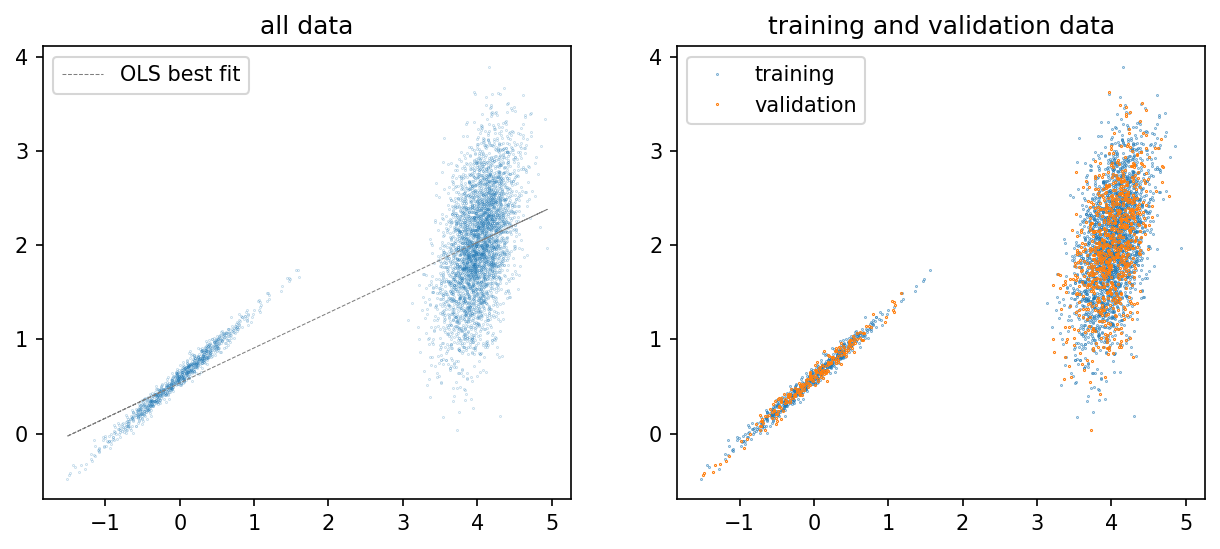

In [9]:
np.random.seed(NP_SEED)
imp.reload(experiments)
imp.reload(plots)
imp.reload(twoDdata)

EXPINFO = experiments.define_experiments(EXP_NAME)

if EXP_NAME.find('olsr')==0:
    imp.reload(twoDdata)
    X_train_std, onehot_train, X_val_std, onehot_val, X_test_std, onehot_test, xmean, xstd, tr_train, tr_val, tr_test = twoDdata.get_data(EXPINFO,to_plot=True)
else:
    imp.reload(climatedata)
    X_train_std, onehot_train, X_val_std, onehot_val, X_test_std, onehot_test, xmean, xstd, tr_train, tr_val, tr_test = climatedata.get_climate_data(EXPINFO,to_plot=False)


# Train the model

In [10]:
def get_tau_vector(model,X):
    y_pred = model.predict(X)

    tau_dict = {}
    for perc in np.around(np.arange(.1,1.1,.1),3):
        tau_dict[perc] =  np.percentile(y_pred[:,-1],100-perc*100.)
    
    return tau_dict

starting training ...
    olsr0_AbstentionLogLoss_setpoint0.1_networkSeed0_npSeed99
    coarse tau = 0.8468921899795532, tau = 0.8468921899795532
Restoring model weights from the end of the best epoch.
Early stopping, setting to best_epoch = 1
        elapsed time during fit = 60.23 seconds



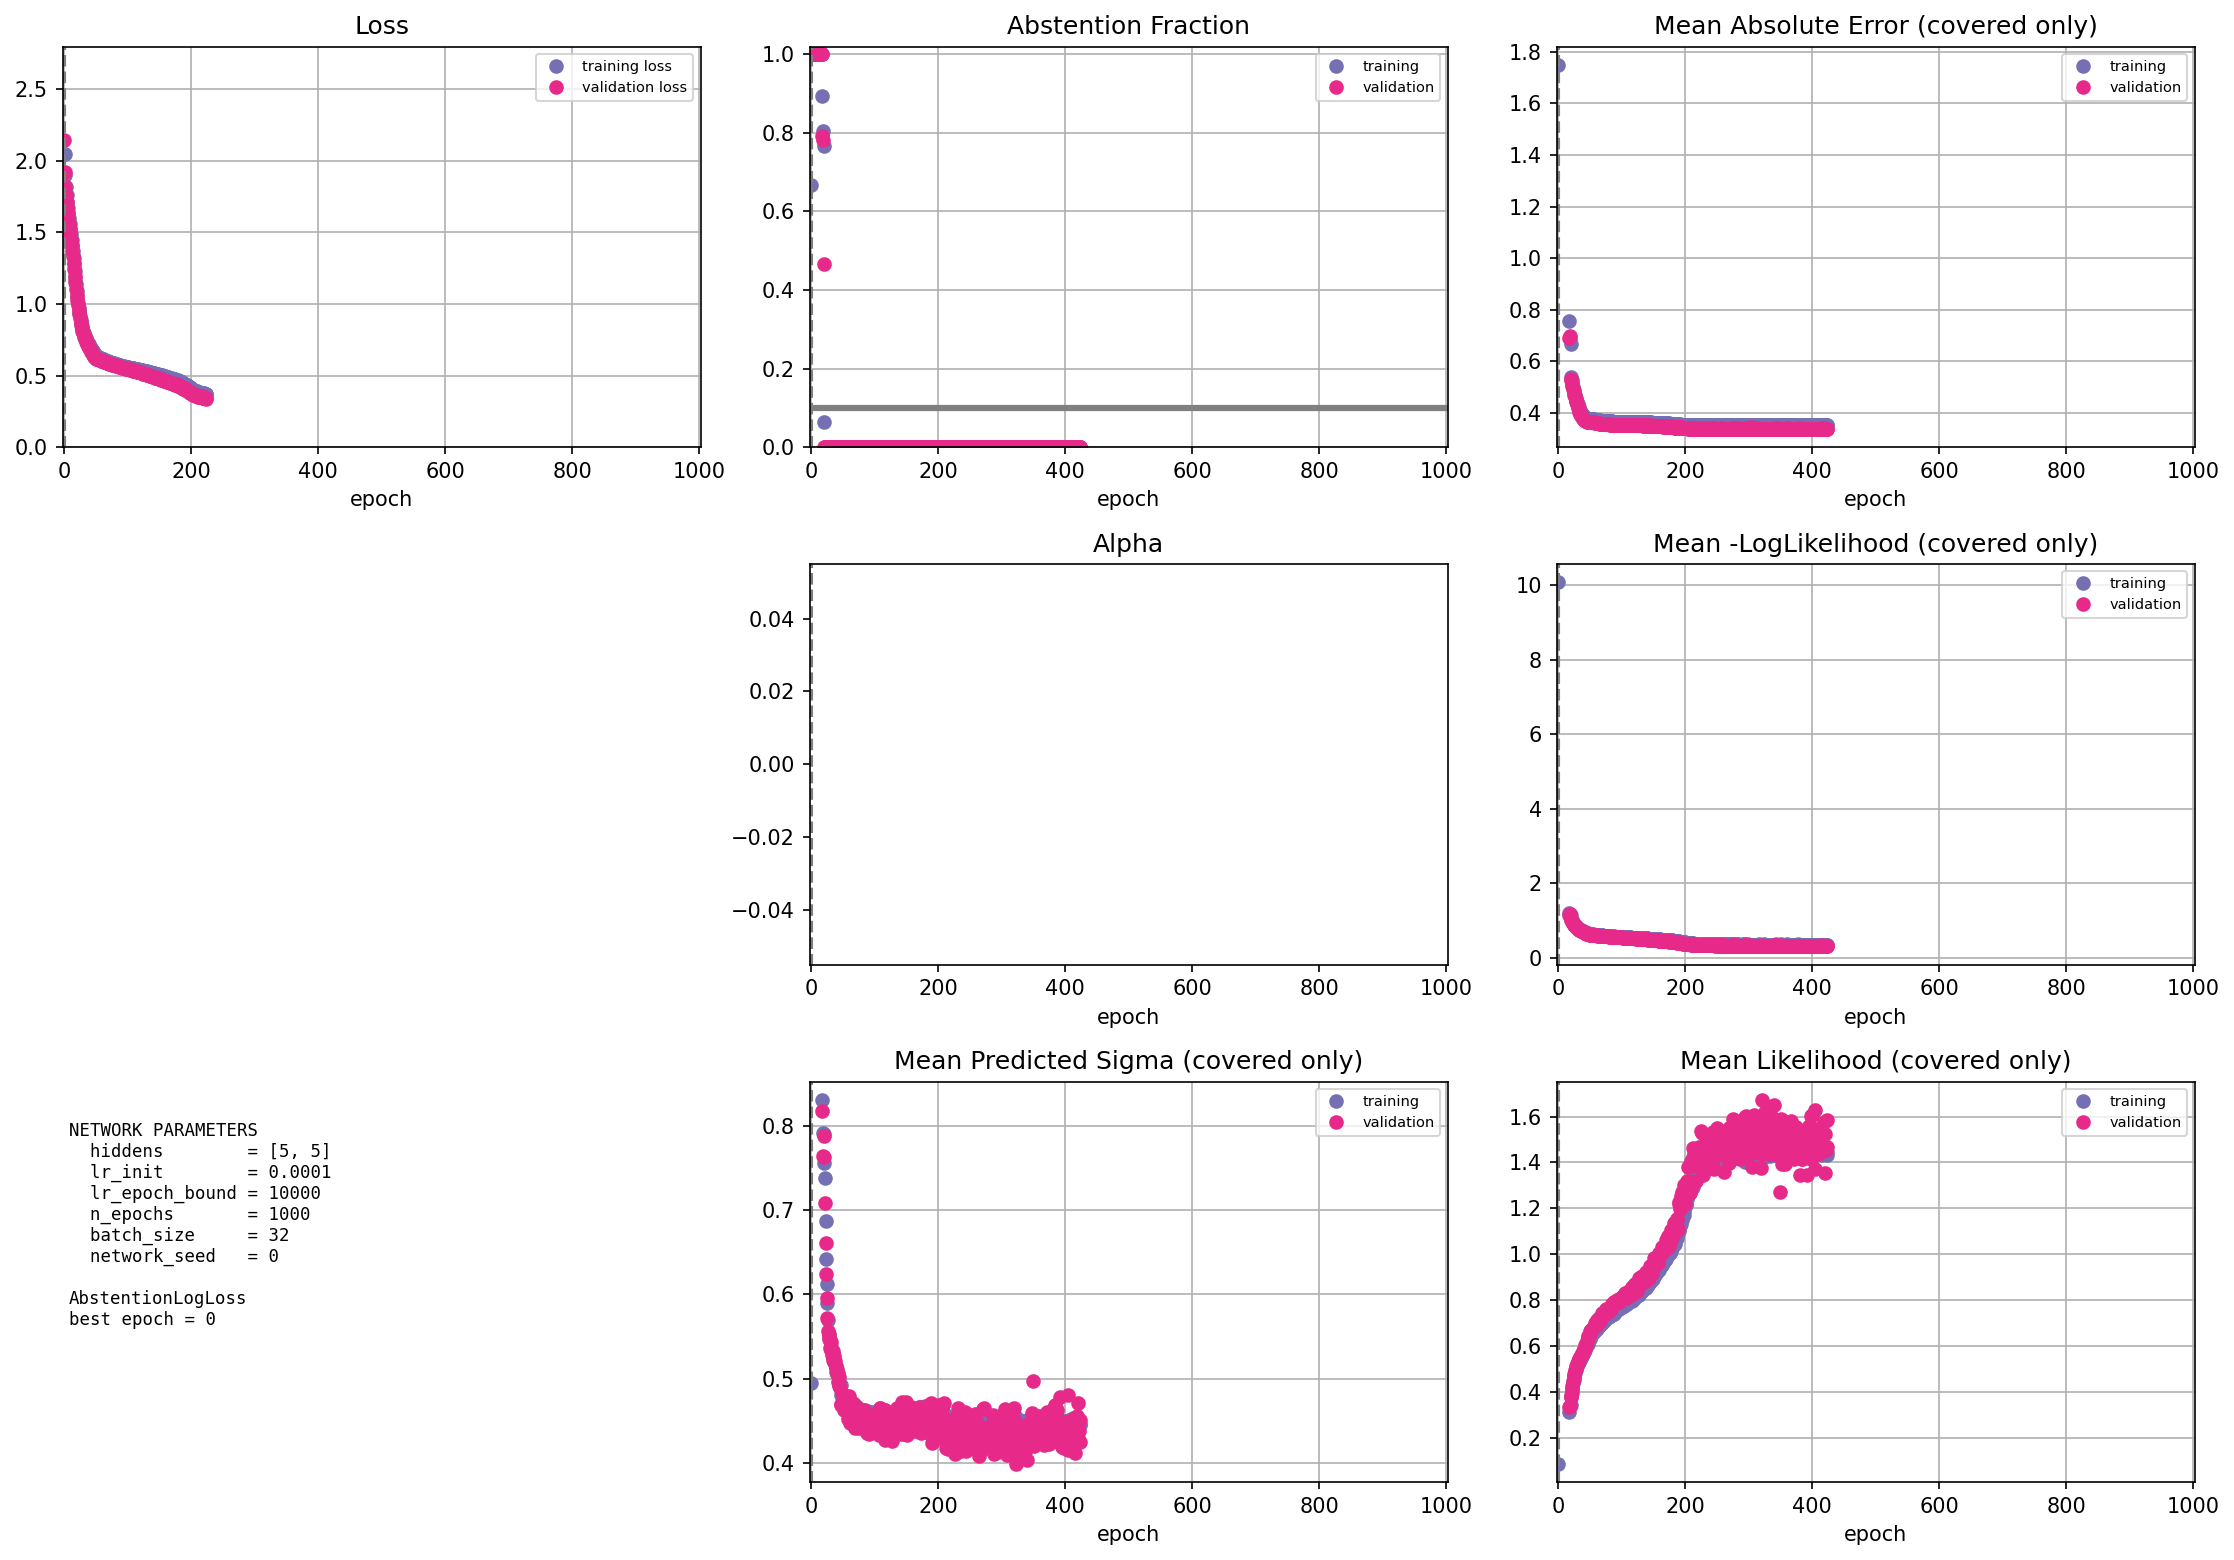

No handles with labels found to put in legend.


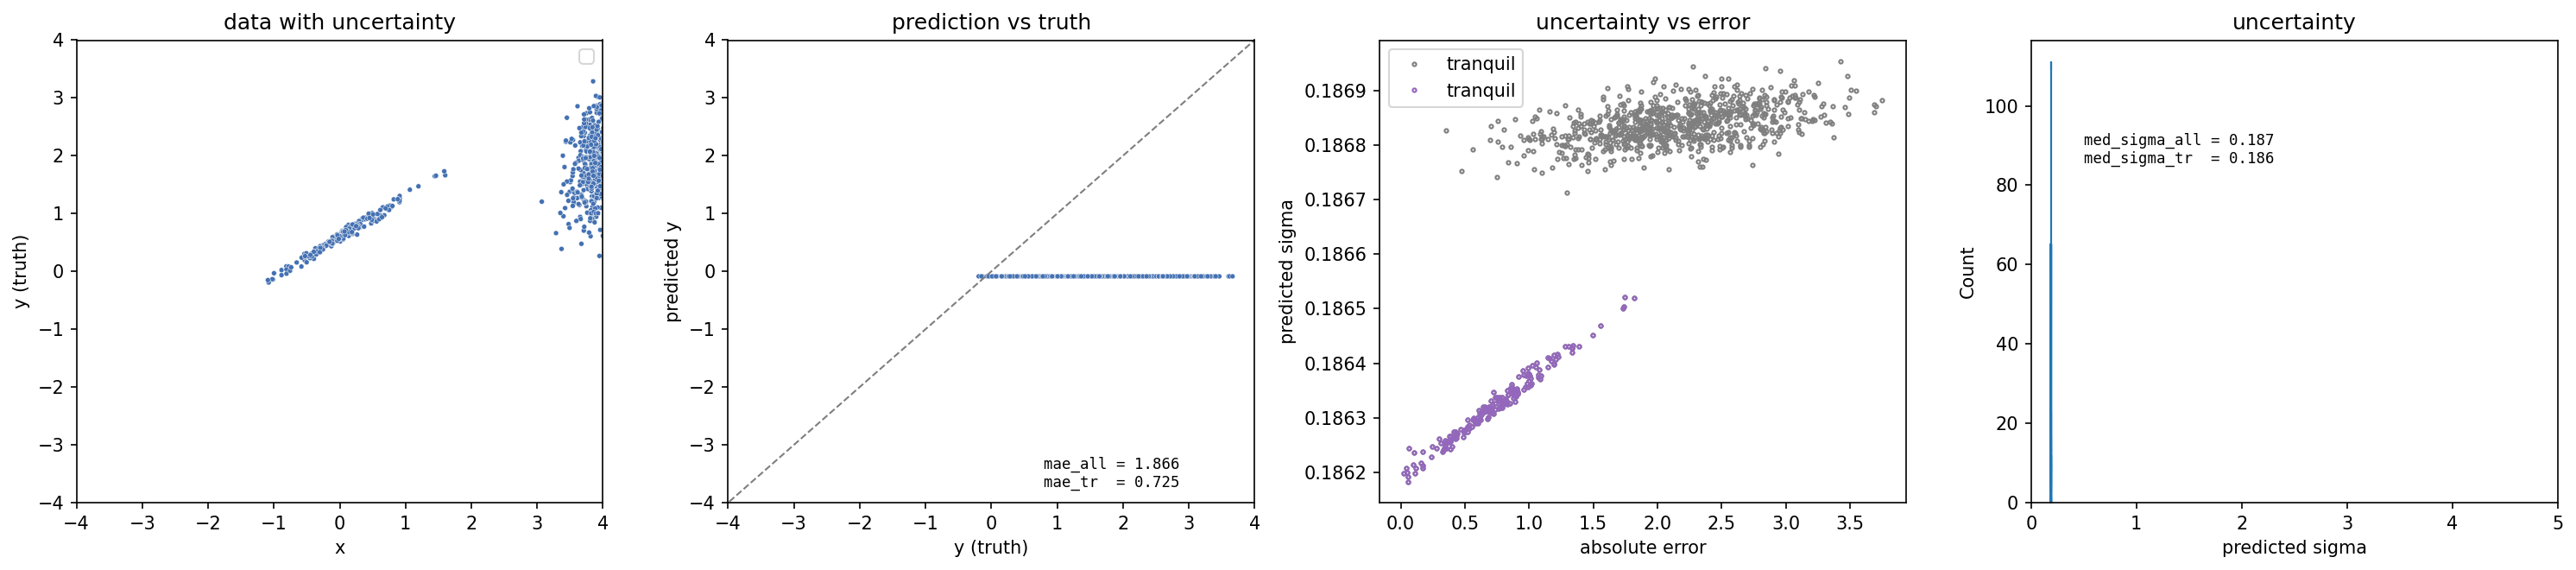

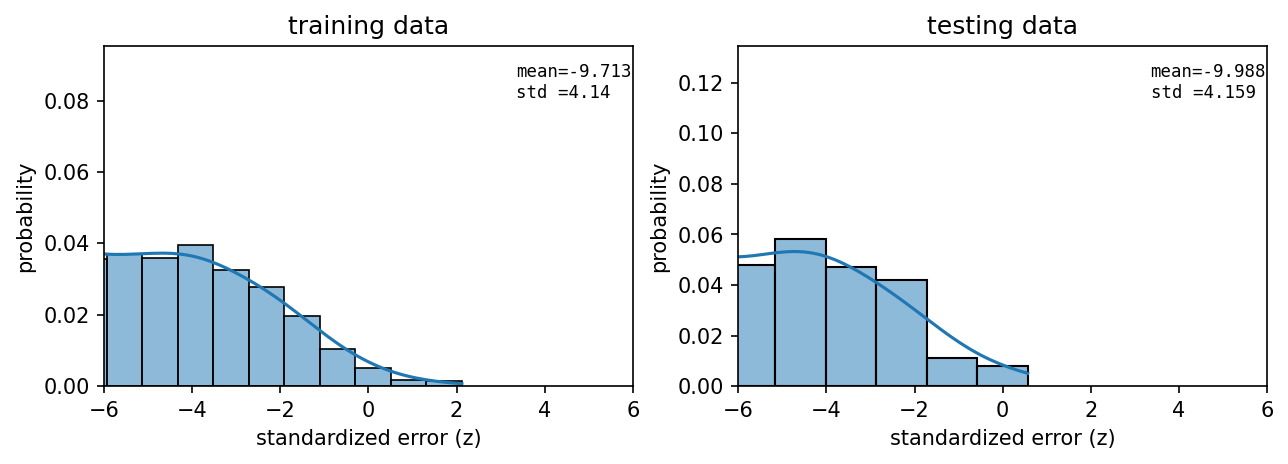


training complete.


In [11]:
imp.reload(abstentionloss)
imp.reload(metrics)
imp.reload(experiments)
imp.reload(plots)
imp.reload(network)

#---------------------
EXPINFO = experiments.define_experiments(EXP_NAME)
LOSS = EXPINFO['loss']
UPDATER = EXPINFO['updater']
ACT_FUN = EXPINFO['act_fun']
NUPD = EXPINFO['nupd']
HIDDENS = EXPINFO['hiddens']
BATCH_SIZE = EXPINFO['batch_size']
LR_INIT = EXPINFO['lr_init']
NUM_CLASSES = EXPINFO['numClasses']
RIDGE = EXPINFO['ridge_param']

COARSE_SETPOINT = EXPINFO['coarse_setpoint']
N_SPINUP_EPOCHS = EXPINFO['n_spinup_epochs']
N_COARSE_EPOCHS = EXPINFO['n_coarse_epochs']
PATIENCE = EXPINFO['patience']

SAVE_HISTORY = True

try:
    fixed_alpha = EXPINFO['fixed_alpha']
except:
    fixed_alpha = np.nan
#---------------------
# Set parameters
REWRITE = True
SAVE_HISTORY = True
LR_EPOCH_BOUND = 10000
#---------------------
SETPOINT_LIST = np.around(np.arange(0.0,1.,.1),3)
SETPOINT_LIST = np.insert(SETPOINT_LIST,0,-1)
# SETPOINT_LIST = [-1.,.1,0.]
# SETPOINT_LIST = [-1.,.1,-2.,0.,]
# SETPOINT_LIST = [-2.,]
SETPOINT_LIST = [.1,]
# SETPOINT_LIST = [0.,-1.,.8,]
# SETPOINT_LIST = [0.,-1.,.8]

if in_ipynb():
    NETWORK_SEED_LIST = (0,)#np.arange(0,5)
else:
    seed_vector = np.arange(0,20)
    NETWORK_SEED_LIST = (int(sys.argv[-1]),)
    if(NETWORK_SEED_LIST[0]>np.max(seed_vector)):
        sys.exit()
        
print('starting training ...')        
for network_seed in NETWORK_SEED_LIST:
    for isetpoint, setpoint in enumerate(SETPOINT_LIST):
        
        # set loss function to use ----
        N_EPOCHS = EXPINFO['n_epochs']
        if(setpoint==0):
            if(LOSS == 'AbstentionLogLoss'):
                RUN_LOSS = 'RegressLogLoss'
            else:
                RUN_LOSS = LOSS
        elif(setpoint==-1):
            if(LOSS == 'AbstentionLogLoss'):
                RUN_LOSS = 'RegressLogLoss'            
                N_EPOCHS = EXPINFO['n_spinup_epochs']
            else:
                continue
        elif(setpoint==-2):
            if(LOSS == 'AbstentionLogLoss'):
                RUN_LOSS = 'StandardMAE'            
            else:
                continue                
        else:            
            if(LOSS != 'AbstentionLogLoss' ):
                continue
            else:
                RUN_LOSS = LOSS
        
        #-------------------
        LONG_NAME = get_long_name(EXP_NAME, RUN_LOSS, setpoint, network_seed, NP_SEED)
        model_name = 'saved_models/model_' +  LONG_NAME

        if(os.path.exists((model_name + '.h5').format(N_EPOCHS)) and REWRITE==False):
            continue
        else:
            print('    ' + LONG_NAME)

        #-------------------------------
        # load the baseline spin-up model
        if(setpoint>0):
            spinup_file = 'saved_models/model_' +  get_long_name(exp_name=EXP_NAME, 
                                                                 loss_str='RegressLogLoss', 
                                                                 setpoint=-1., 
                                                                 network_seed=network_seed, 
                                                                 np_seed=NP_SEED)
            model_spinup, __ = make_model(loss_str = RUN_LOSS,
                                          network_seed=network_seed,
                                         )
            model_spinup.load_weights(spinup_file + '.h5')
            tau_dict = get_tau_vector(model_spinup,X_val_std)
            TAU_COARSE = tau_dict[COARSE_SETPOINT]
            TAU = tau_dict[setpoint]
            print('    coarse tau = ' + str(TAU_COARSE) + ', tau = ' + str(TAU))            
        else:
            TAU = np.nan
            TAU_COARSE = np.nan
            
        #-------------------------------
        # set random seed again
        np.random.seed(NP_SEED)
        # get the model
        tf.keras.backend.clear_session()
        
        # callbacks
        lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpointDir + 'model_' + LONG_NAME + '_epoch{epoch:03d}.h5', 
            verbose=0, 
            save_weights_only=True,
        )

        # define the model and loss function
        if(RUN_LOSS=='AbstentionLogLoss'):
            es_dac_callback = EarlyStoppingDAC(patience=PATIENCE, 
                                               updater_str=UPDATER,
                                              )
            model, loss_function = make_model(loss_str = RUN_LOSS, 
                                              updater_str=UPDATER, 
                                              tau_coarse = TAU_COARSE,                                              
                                              tau = TAU,
                                              spinup_epochs=N_SPINUP_EPOCHS, 
                                              coarse_epochs=N_COARSE_EPOCHS,
                                              setpoint=setpoint, 
                                              nupd=NUPD,
                                              network_seed=network_seed,
                                             )
            callbacks = [abstentionloss.AlphaUpdaterCallback(), 
                         lr_callback, 
                         cp_callback,
                         es_dac_callback,
                        ]
        else:
            es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           mode='min',
                                                           patience=PATIENCE, 
                                                           restore_best_weights=True, 
                                                           verbose=1)                    
            model, loss_function = make_model(loss_str = RUN_LOSS,
                                              network_seed=network_seed,
                                             )
            callbacks = [lr_callback, 
                         cp_callback, 
                         es_callback,
                        ]            

        #-------------------------------
        # Train the model
        start_time = time.time()
        history = model.fit(
                            X_train_std,
                            onehot_train,
                            validation_data=(X_val_std, onehot_val),
                            batch_size=BATCH_SIZE,
                            epochs=N_EPOCHS,
                            shuffle=True,
                            verbose=0,
                            callbacks=callbacks
                        )        
        if(SAVE_HISTORY):
            # save history data
            history_dict = model.history.history
            history_file = 'saved_models/history_' +  LONG_NAME + '.pickle'
            with open(history_file, 'wb') as handle:
                pickle.dump(history_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

        stop_time = time.time()
        tf.print(f"        elapsed time during fit = {stop_time - start_time:.2f} seconds\n")

        model.save_weights(model_name + '.h5')
        for f in glob.glob(checkpointDir + 'model_' + LONG_NAME + "_epoch*.h5"):
            os.remove(f)        

        #-------------------------------
        # Display the results
        if(RUN_LOSS=='AbstentionLogLoss'):
            best_epoch = es_dac_callback.best_epoch
        elif(setpoint==-1):
            best_epoch = N_EPOCHS 
        else:
            best_epoch = np.argmin(history.history['val_loss'])
        exp_info=(RUN_LOSS, N_EPOCHS, setpoint, N_SPINUP_EPOCHS, HIDDENS, LR_INIT, LR_EPOCH_BOUND, BATCH_SIZE, network_seed, best_epoch)

        #---- plot training diagnostics ----
        plots.plot_diagnostics(
            LONG_NAME,
            history,
            exp_info=exp_info,
            saveplot=True,
            showplot=True,
        )

        #---- plot nice predictions ----
        y_pred = model.predict(X_test_std)
        plots.plot_predictionscatter(X_test_std, y_pred, onehot_test[:,0], tr_test, LONG_NAME, showplot = True)
        
        #---- look at errors ----
        plt.figure(figsize=(10,3))
        #........................
        ax=plt.subplot(1,2,1)
        y_pred = model.predict(X_train_std)
        err = (y_pred[:,0] - onehot_train[:,0])/y_pred[:,1]        
        sns.histplot(err, kde=True, stat='probability')
        text = 'mean=' + str(np.round(np.mean(err),3)) + '\nstd =' + str(np.round(np.std(err),3))
        plt.text(0.78, 0.95, text, fontfamily='monospace', fontsize='small', va='top',transform=ax.transAxes)
        plt.xlim(-6,6)
        plt.xlabel('standardized error (z)')
        plt.ylabel('probability')
        plt.title('training data')        
        #........................
        ax=plt.subplot(1,2,2)
        y_pred = model.predict(X_test_std)
        err = (y_pred[:,0] - onehot_test[:,0])/y_pred[:,1]        
        sns.histplot(err, kde=True, stat='probability')
        text = 'mean=' + str(np.round(np.mean(err),3)) + '\nstd =' + str(np.round(np.std(err),3))
        plt.text(0.78, 0.95, text, fontfamily='monospace', fontsize='small', va='top',transform=ax.transAxes)
        plt.xlim(-6,6)
        plt.xlabel('standardized error (z)')
        plt.ylabel('probability')
        plt.title('testing data')
        plt.show()
        #--------------------------

print('\ntraining complete.')                
if in_ipynb()==False:    
    print('-----starting new kernel-----')                
    os.execv(sys.executable, ['python'] + ['/Users/eabarnes/GoogleDrive/WORK/RESEARCH/2021/abstention_networks/regression/' + SCRIPT_NAME] + [str(network_seed+1)])        
    print('-----exiting...')        
    sys.exit() 